In [1]:
import re 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from xgboost import XGBClassifier
import joblib


In [2]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

!kaggle datasets download -d shivamb/real-or-fake-fake-jobposting-prediction --unzip


Dataset URL: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction
License(s): CC0-1.0




  0%|          | 0.00/16.1M [00:00<?, ?B/s]
100%|██████████| 16.1M/16.1M [00:00<00:00, 794MB/s]


In [3]:
df =  pd.read_csv("fake_job_postings.csv")


In [4]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
df.shape

(17880, 18)

In [6]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
columns = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']

In [8]:
for col in columns:
    del df[col]
    

In [9]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [10]:
df.fillna('', inplace=True)

In [11]:
df['function'].nunique()

38

In [12]:
df['function'].value_counts()

function
                          6455
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Other                      325
Education                  325
Management                 317
Business Development       228
Accounting/Auditing        212
Human Resources            205
Project Management         183
Finance                    172
Consulting                 144
Writing/Editing            132
Art/Creative               132
Production                 116
Product Management         114
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                82
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46

In [13]:
# # Step 1: Count frequency of each value in 'function'
# function_counts = df['function'].value_counts()

# # Step 2: Get only the functions that appear more than 300 times
# frequent_functions = function_counts[function_counts > 300].index

# # Step 3: Replace infrequent values with NaN (or 'Other')
# df['function'] = df['function'].where(df['function'].isin(frequent_functions), other='Other')


In [14]:
df['function'].unique()

array(['Marketing', 'Customer Service', '', 'Sales',
       'Health Care Provider', 'Management', 'Information Technology',
       'Other', 'Engineering', 'Administrative', 'Design', 'Production',
       'Education', 'Supply Chain', 'Business Development',
       'Product Management', 'Financial Analyst', 'Consulting',
       'Human Resources', 'Project Management', 'Manufacturing',
       'Public Relations', 'Strategy/Planning', 'Advertising', 'Finance',
       'General Business', 'Research', 'Accounting/Auditing',
       'Art/Creative', 'Quality Assurance', 'Data Analyst',
       'Business Analyst', 'Writing/Editing', 'Distribution', 'Science',
       'Training', 'Purchasing', 'Legal'], dtype=object)

In [15]:
rename_function = {
    'Marketing': 'MKT',
    'Customer Service': 'CS',
    '': 'Unknown',
    'Sales': 'SLS',
    'Health Care Provider': 'HCP',
    'Management': 'MGMT',
    'Information Technology': 'IT',
    'Other': 'OTH',
    'Engineering': 'ENG',
    'Administrative': 'ADMIN',
    'Design': 'DSN',
    'Production': 'PRD',
    'Education': 'EDU',
    'Supply Chain': 'SCM',
    'Business Development': 'BD',
    'Product Management': 'PM',
    'Financial Analyst': 'FA',
    'Consulting': 'CNSLT',
    'Human Resources': 'HR',
    'Project Management': 'PJM',
    'Manufacturing': 'MFG',
    'Public Relations': 'PR',
    'Strategy/Planning': 'STRAT',
    'Advertising': 'ADV',
    'Finance': 'FIN',
    'General Business': 'BUS',
    'Research': 'R&D',
    'Accounting/Auditing': 'ACCT',
    'Art/Creative': 'ART',
    'Quality Assurance': 'QA',
    'Data Analyst': 'DA',
    'Business Analyst': 'BA',
    'Writing/Editing': 'WRIT',
    'Distribution': 'DIST',
    'Science': 'SCI',
    'Training': 'TRNG',
    'Purchasing': 'PURCH',
    'Legal': 'LEGAL'
}


In [16]:
df['function_abbr'] = df['function'].replace(rename_function)
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,function_abbr
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,MKT
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,CS
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,Unknown
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,SLS
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,HCP


In [17]:
# Alternative to select the function_abb with highest counts    (this can later be used in plots to plot only the top results)

top_fun = df['function_abbr'].value_counts().head(10).index
top_fun

Index(['Unknown', 'IT', 'SLS', 'ENG', 'CS', 'MKT', 'ADMIN', 'DSN', 'HCP',
       'OTH'],
      dtype='object', name='function_abbr')

In [18]:
df.columns

Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent', 'function_abbr'],
      dtype='object')

In [19]:
# Adding required column at required position (before target column)

# Get the list of current columns
cols = list(df.columns)

# Remove 'function_abbr' from its current position
cols.remove('function_abbr')

# Insert 'function_abbr' before 'target'
cols.insert(cols.index('fraudulent'), 'function_abbr')

# Reorder the DataFrame
df = df[cols]

In [20]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,function_abbr,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,MKT,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,CS,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,Unknown,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,SLS,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,HCP,0


In [21]:
df = df.loc[:, ~df.columns.duplicated()]                # keep only the first instance of any duplicated column

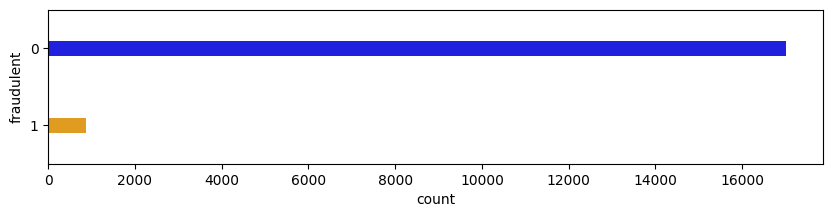

In [22]:
fig = plt.figure(figsize=(10, 2))
sns.countplot(data=df, 
              y = 'fraudulent', 
              hue = 'fraudulent', 
              palette= {0: 'blue', 1: 'orange'}, 
              legend=False,
              width=0.2
              )
plt.show()

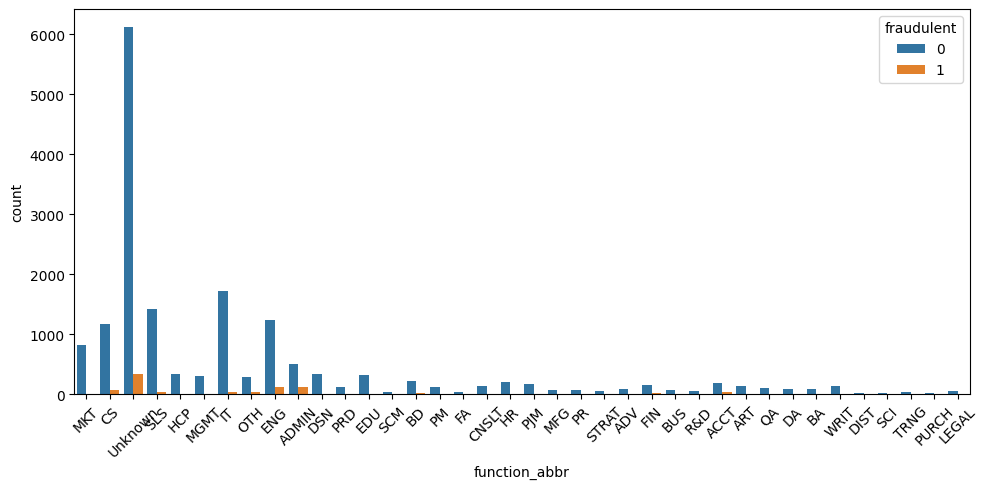

In [23]:
fig = plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='function_abbr', hue='fraudulent')                  # categorical vs categorical

# df_top = df[df['function_abbr'].isin(top_functions)]                         # for top results
# sns.countplot(data=df_top, x='function_abbr', hue='fraudulent') 

# to add rotated labels for classes in x-axis to make it more visible
plt.xticks(rotation=45)
plt.tight_layout()
# (if rotating names doesn't work then, try by changing axis from x to y for more space)

plt.show()

note for self:
plt.tight_layout() is a Matplotlib function that automatically adjusts subplot parameters (like spacing and margins) so that:

Labels, ticks, and titles don’t get cut off

Axis labels and x-tick labels (especially when rotated) stay visible

The plot makes better use of the available space

In [24]:
df.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [25]:
exp = dict(df.required_experience.value_counts())
del exp['']

In [26]:
exp

{'Mid-Senior level': np.int64(3809),
 'Entry level': np.int64(2697),
 'Associate': np.int64(2297),
 'Not Applicable': np.int64(1116),
 'Director': np.int64(389),
 'Internship': np.int64(381),
 'Executive': np.int64(141)}

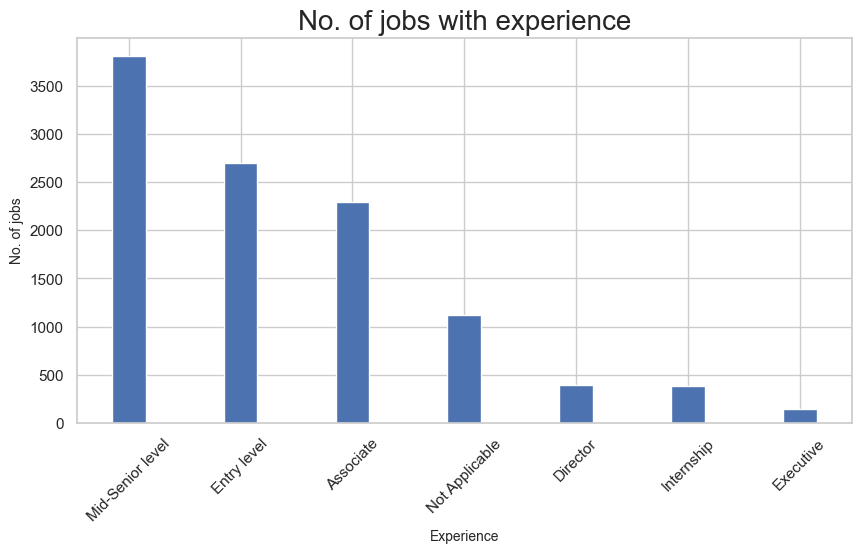

In [27]:
plt.figure(figsize=(10,5))
sns.set_theme(style= 'whitegrid')
plt.bar(exp.keys(), exp.values(), width=0.3)
plt.title('No. of jobs with experience', size= 20)
plt.xlabel('Experience', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=45)
plt.show()

In [28]:
df.location = df['location'].str.split(',').str[-1]

In [29]:
df.location.head(14)

0           New York
1           Auckland
2              Wever
3         Washington
4         Fort Worth
5                   
6             Berlin
7      San Francisco
8          Pensacola
9            Phoenix
10       Jersey City
11            London
12          Stamford
13           Orlando
Name: location, dtype: object

In [30]:
place = dict(df.location.value_counts()[:10])               # top_15 places with job posting
del place['']
del place[' ']
place

{' London': np.int64(1069),
 ' New York': np.int64(669),
 ' Athens': np.int64(553),
 ' San Francisco': np.int64(477),
 ' Houston': np.int64(272),
 ' Berlin': np.int64(262),
 ' Chicago': np.int64(257),
 ' Washington': np.int64(255)}

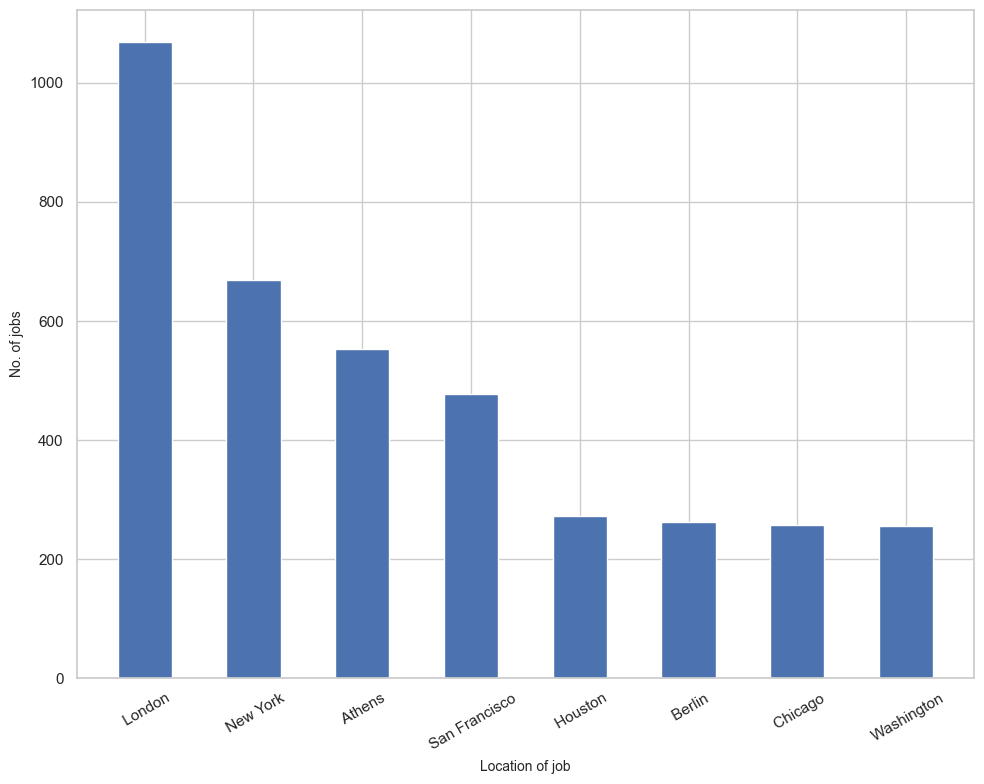

In [31]:
plt.figure(figsize=(10,8))
plt.bar(place.keys(), place.values(), width=0.5)
plt.xlabel("Location of job", size= 10)
plt.ylabel("No. of jobs", size =10)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [32]:
edu = dict()

In [33]:
print(df[df.fraudulent==0].title.value_counts()[:10])

title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: count, dtype: int64


In [34]:
print(df[df.fraudulent==1].title.value_counts()[:10])

title
Data Entry Admin/Clerical Positions - Work From Home                    21
Cruise Staff Wanted *URGENT*                                            21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Network Marketing                                                       10
Payroll Clerk                                                           10
Name: count, dtype: int64


In [35]:
df['text'] = df['title'] + ' ' +df['company_profile']  + ' ' + df['department'] + ' ' + df['description'] + '  ' + df['function'] + ' ' + df['function_abbr'] + ' ' + df['industry'] + ' ' + df['location'] + ' ' + df['required_education'] + ' ' + df['required_experience']+ ' ' + df['requirements'] 

In [36]:
del df['benefits']
del df['company_profile']
del df['department']
del df['description']
del df['function']
del df['function_abbr']
del df['industry']
del df['location']
del df['required_education']
del df['required_experience']
del df['requirements']
del df['title']

In [37]:
df.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've creat..."
1,0,Customer Service - Cloud Video Production 90 S...
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...


In [38]:
fraud_jobstext = df[df.fraudulent==1].text
real_jobstext = df[df['fraudulent']==0].text

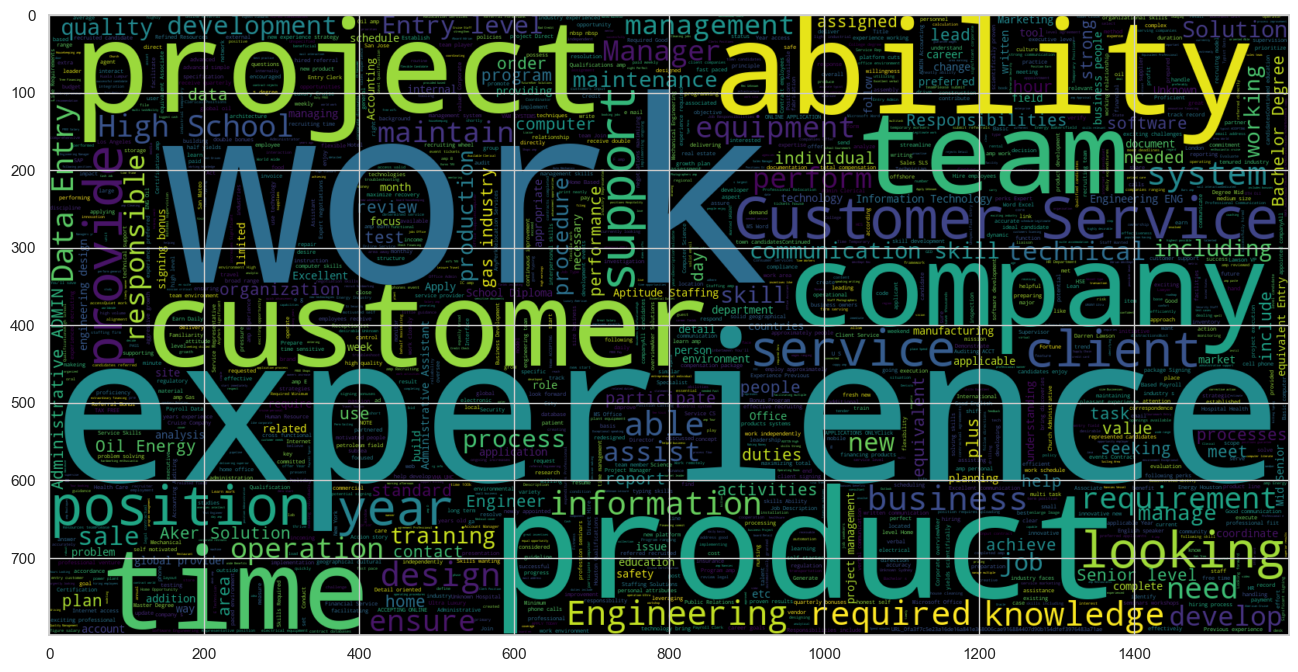

In [39]:
StopWords = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize= (16, 14))
wc = WordCloud(min_font_size   =3, max_words =3000, width =1600, height =800, stopwords= StopWords).generate(str(" ".join(fraud_jobstext)))
plt.imshow(wc, interpolation= 'bilinear')

(" ".join(fraud_jobstext) joins the strings in series, i.e joins all the senences in the column.

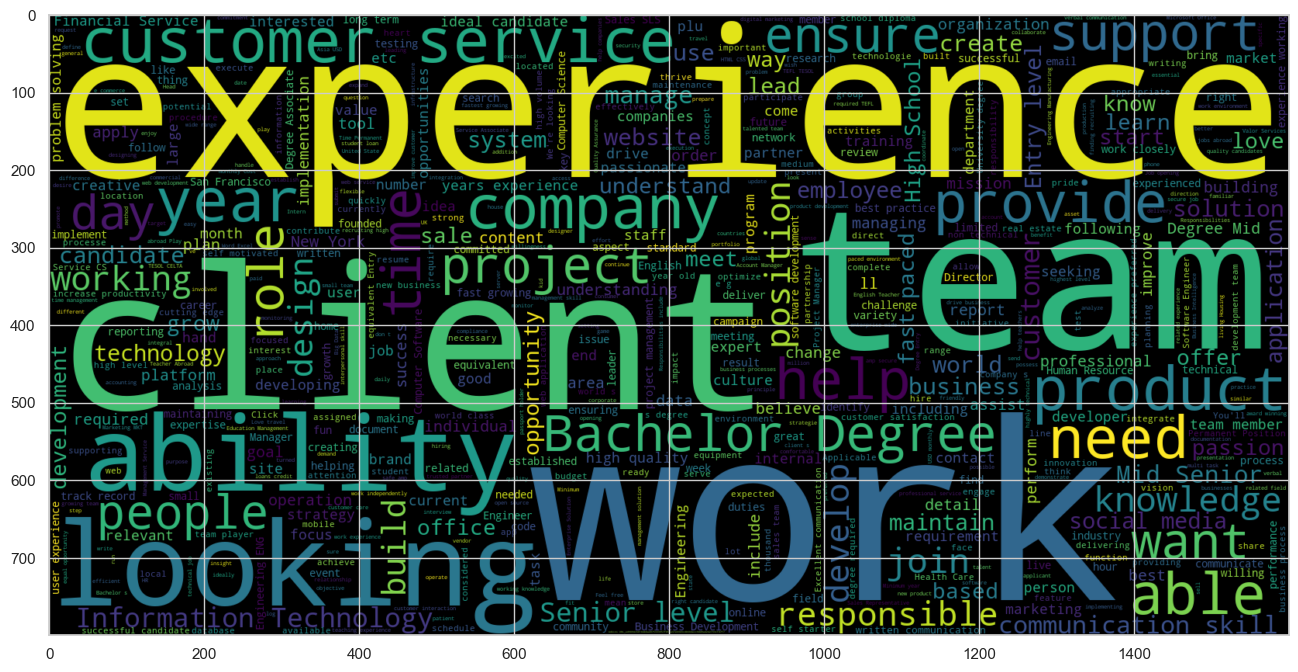

In [40]:
plt.figure(figsize= (16, 14))
wc = WordCloud(min_font_size   =3, max_words =3000, width =1600, height =800, stopwords= StopWords).generate(str(" ".join(real_jobstext)))
plt.imshow(wc, interpolation= 'bilinear')

NLP pipeline 


In [41]:
import spacy.cli
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [42]:
!pip install spacy && python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [43]:
from spacy.lang.en import English
from sklearn.base import TransformerMixin

remove stopwords
sentence sengmentation
word tokenizer

In [44]:
import string
punctuations = string.punctuation

nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON" else word.lower() for word in mytokens]
    
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    return mytokens

class predictors(TransformerMixin):
    def transformer(self, X, **transform_params):
        
        return [clean_text(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return{}
    
def clean_text(text):
    return text.strip().lower()


In [45]:
df.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've creat..."
1,0,Customer Service - Cloud Video Production 90 S...
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...


In [46]:
df['text'] =df['text'].apply(clean_text)

vectorization of word to vec using tf-idf

In [50]:
cv = TfidfVectorizer(max_features=100)
x = cv.fit_transform(df['text'])
df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names_out())
df.drop(["text"], axis =1, inplace=True)
main_df = pd.concat([df1, df], axis=1)

In [55]:
joblib.dump(cv,'vectorizer.joblib')

['vectorizer.joblib']

In [53]:
df.head()

,fraudulent
0,0
1,0
2,0
3,0
4,0


In [54]:
main_df.head()

,ability,about,all,amp,an,and,are,as,at,based,...,who,will,with,work,working,world,years,you,your,fraudulent
0,0.000000,0.041319,0.000000,0.037218,0.000000,0.739307,0.000000,0.078594,0.000000,0.000000,...,0.0,0.000000,0.183628,0.051696,0.069420,0.000000,0.000000,0.000000,0.000000,0
1,0.027900,0.061003,0.046183,0.054948,0.000000,0.516255,0.054586,0.058018,0.068152,0.028508,...,0.0,0.020060,0.120493,0.057243,0.076869,0.096717,0.000000,0.061769,0.049497,0
2,0.000000,0.000000,0.182146,0.043343,0.091211,0.395586,0.114819,0.000000,0.000000,0.000000,...,0.0,0.063292,0.308894,0.060204,0.000000,0.000000,0.000000,0.097446,0.078086,0
3,0.025294,0.000000,0.020934,0.000000,0.104830,0.681980,0.000000,0.035065,0.041190,0.000000,...,0.0,0.054557,0.081927,0.034597,0.000000,0.116908,0.021403,0.055998,0.067309,0
4,0.000000,0.000000,0.070123,0.041716,0.029262,0.604695,0.082881,0.117457,0.000000,0.000000,...,0.0,0.000000,0.160083,0.028972,0.038905,0.000000,0.035846,0.031263,0.112731,0


In [49]:
Y = main_df.iloc[:, -1]
X = main_df.iloc[:, :-1]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)


In [50]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(12516, 100)
(5364, 100)
(12516,)
(5364,)


In [51]:
from sklearn.ensemble import RandomForestClassifier
RandForest = RandomForestClassifier(n_jobs=3, oob_score=True, n_estimators=100, criterion= "entropy")
rf_model = RandForest.fit(X_train, Y_train)

In [52]:
rf_pred = RandForest.predict(X_test)                       # predicts X-test's y_test using rf

In [53]:
score = accuracy_score(Y_test, rf_pred)*100

In [54]:
score

96.97986577181209

In [56]:
print("Classification Report\n")
print(classification_report(Y_test, rf_pred))
print("Confusion Matrix\n")
print(confusion_matrix(Y_test, rf_pred))

Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5095
           1       0.99      0.40      0.57       269

    accuracy                           0.97      5364
   macro avg       0.98      0.70      0.78      5364
weighted avg       0.97      0.97      0.96      5364

Confusion Matrix

[[5094    1]
 [ 161  108]]


In [80]:

xgb = XGBClassifier(n_estimators= 50)
xgb_model = xgb.fit(X_train, Y_train)


In [81]:
# You can add training time and prediction time in your analysis as well.

# rfc = RandomForestClassifier(n_estimators=10)
# training_start = time.perf_counter()
# rfc.fit(X_train, y_train)
# training_end = time.perf_counter()
# prediction_start = time.perf_counter()
# preds = rfc.predict(X_test)
# prediction_end = time.perf_counter()

# acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
# rfc_train_time = training_end-training_start
# rfc_prediction_time = prediction_end-prediction_start

In [82]:
xgb_pred = xgb.predict(X_test)

In [83]:
score_xgb = accuracy_score(Y_test, xgb_pred)*100
score_xgb

97.44593586875466

In [84]:
results = {
    "Random Forest": score,
    "XGBoost": score_xgb
}

for model, acc in results.items():
    print(f"{model} Accuracy: {acc:.2f}%")

Random Forest Accuracy: 96.98%
XGBoost Accuracy: 97.45%


In [ ]:
# # 1. Define your model
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# 2. List the values you want to test
# param_grid = {
#     'n_estimators': [150, 100],         # Try 50 trees and 100 trees
#     'max_depth': [3, 5],               # Try trees with max depth 3 and 5
#     'learning_rate': [0.3, 0.2],       # Try two learning rates
#     'n_jobs': [100]
# }

# # 3. Use GridSearchCV to search for the best combination
# grid_search = GridSearchCV(estimator=xgb,
#                            param_grid=param_grid,
#                            scoring='accuracy',
#                            cv=3,           # 3-fold cross-validation
#                            verbose=1)      # Shows progress

# # 4. Fit the grid search to your training data
# grid_search.fit(X_train, Y_train)

# # 5. Print the best combo found
# print("Best hyperparameters:", grid_search.best_params_)
# print("Best accuracy from tuning:", grid_search.best_score_ * 100)

joblib	= .pkl	= Best for scikit-learn, XGBoost, etc.
pickle	= .pkl	= Generic Python objects (slower than joblib)
xgb.save_model() = .json or .model	= If you want XGBoost-native format
ONNX, PMML = .onnx =	For cross-platform use (advanced)

In [87]:
joblib.dump(xgb,'xgb_model.joblib')

['xgb_model.joblib']